# Clustering

This script performs the clustering algorithm. It contains the following steps:

- Padding reads with the reference genome to fill empty spaces
- Sliding a window over the region of interest to identify reads

# Load modules

In [206]:
import numpy as np
import pandas as pd
import json

from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

# Import data

In [207]:
# Import Nanopore reads
nanopore_reads = pd.read_csv('../data/processed/bioliquid_chr17_pompe_reads_nogaps.csv')

# Import reference genome for the location of interest without gaps
with open('../data/processed/reference_genome_chr17_nogaps.json', 'r') as f:
    ref_genome_json = json.load(f)
    
ref_genome = ref_genome_json['reference_genome']

# Helper functions

In [208]:
# Define hyper-parameters
window_width = 5000 # 5k BP
jump_width = 1000 # 1k BP sliding window (ideally jump_width=1)

# check if the start of a sequence is in range
def check_sliding_window(read):
    read_filter = False
    window = set(list(range(left_bound,right_bound)))
    read = set(list(range(read['POS'],read['END_POS'])))
    if len(window & read)>0:
        read_filter = True
    return read_filter

# Input: read --> Series
# Output: nucleotide_sequence_trimmed: String

def left_pad_read(read):
    nucleotide_sequence = list(read['SEQ']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)
    
    start = read['POS']-left_bound

    if start == 0:
        return read['SEQ'] # read starts on the start of the window
    
    elif start > 0: # sequence starts to the right of the bound
#         print('HERE1')
#         genome_fill = window_ref_genome[:start] # select portion of reference genome to pad the left with
        genome_fill = genome_sequence[:start] # select portion of reference genome to pad the left with
#         print('genome_fill type:', type(genome_fill))
#         print('nucleotide_sequence type:', type(nucleotide_sequence))
        nucleotide_sequence = genome_fill+nucleotide_sequence
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
        return nucleotide_sequence_trimmed
    
    elif start < 0: # sequence starts to the left of the bound
#         print('HERE2')
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[np.abs(start):])
        return nucleotide_sequence_trimmed

# Input: read --> Series
# Output: nucleotide_sequence_trimmed: String

def right_pad_read(read):
    nucleotide_sequence = list(read['left_padded']) # turn sequence string into a list
    genome_sequence = list(window_ref_genome)

    end = right_bound-read['END_POS']

    if end == 0:
        return read['left_padded'] # read end on the end of the window
    
    elif end > 0: # sequence ends to the left of the bound
#         genome_fill = window_ref_genome[-end:] # select portion of reference genome to pad the right with
        genome_fill = genome_sequence[-end:] # select portion of reference genome to pad the right with
        nucleotide_sequence = nucleotide_sequence+genome_fill
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence) # keep entire sequence
        return nucleotide_sequence_trimmed
    
    elif end < 0: # sequence ends to the right of the bound
        nucleotide_sequence_trimmed = ''.join(nucleotide_sequence[:end])
        return nucleotide_sequence_trimmed

# Should be updated
NUCLEOTIDE_VOCABULARY = [
    'A','C','G','T','X'
]
        
# Not being used, instead, we use the sklearn one hot encoding
def nucleotide_to_one_hot(nucleotide_sequence):
    to_return = []
    for char in nucleotide_sequence:
        if char in NUCLEOTIDE_VOCABULARY:
            to_append = np.zeros(len(NUCLEOTIDE_VOCABULARY))
            to_append[NUCLEOTIDE_VOCABULARY.index(char)] = 1.
            to_return.append(to_append)
        else:
            raise ValueError('Could not one-hot code character {}'.format(char))
    return np.array(to_return)

#nucleotide_to_one_hot('GTCATACX') # uncomment example to see what the encoding does

# Input: read (Series)

# Text file for results
def write_results_to_file(read, results_file):
    results_file.write(f"{read['ID']},{read['kmeans_cls2']}\n")
#     TODO: Add window number
#     results_file.close()

# Main Loop: padding and clustering

### Create results file

In [209]:
chromosomeID = 'chr17'
results_file_path = f"../data/processed/{chromosomeID}_read_clusters.txt"
results_file = open(results_file_path,"w")
# results_file = open(results_file_path,"a")

# window_ref_genome_start = 0
iter = 1
empty_count = 0
print(f"Total range: {max(nanopore_reads['END_POS']):,}")
print(f"Window width: {window_width}")
print(f"Jump width: {jump_width}")
total_jumps = round(max(nanopore_reads['END_POS'])/jump_width)
print(f"Number of iterations required: {total_jumps}")
print(f"Writing results to file: {results_file_path}")
print(f"Iterations: ", end="")

for left_bound in range(min(nanopore_reads['POS']),max(nanopore_reads['END_POS']),jump_width):
    
    progress = iter/total_jumps
#     print(f" {progress:.0f}% ", end="")
    if round(progress*1000)%50==0:
        print(f" {round(progress*100):.0f}% ", end="")
    iter+=1
        
    right_bound = left_bound+window_width
    window_ref_genome = ref_genome[left_bound:left_bound+window_width]
    
    # Identify if each read is in the window: True/False
#     print("Identifying if each read is in the window...")
    nanopore_reads['read_filter'] = nanopore_reads.apply(lambda x: check_sliding_window(x), axis=1)
    
    # Get them
    window_reads = nanopore_reads.loc[nanopore_reads['read_filter']==True]
    window_reads = window_reads.reset_index()
    
    # Display feedback to user every 100 empty windows
#     if empty_count%100 == 0:
#         print(empty_count)

    if len(window_reads) == 0:
        # There are no nanopore reads in this window (next window)
#         window_ref_genome_start += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        print(f"-", end="")
        continue 
        
    elif len(window_reads) == 1:
        # There is only one read in this window (next window) - TODO: TALK WITH TEAM ABOUT THIS
#         window_ref_genome_start += jump_width # move the starting cutoff for the reference genome with the sliding window
        empty_count += 1
        print(f"1", end="")
        continue
        
    ## If it gets here, there is more than one sequence overlapping in the window (continue algorithm to encoding and clustering steps) ##
    
#     print("Applying padding...")
    window_reads['left_padded'] = window_reads.apply(lambda x: left_pad_read(x), axis=1) # fill reference genome on the left of the read
    window_reads['right_padded'] = window_reads.apply(lambda x: right_pad_read(x), axis=1) # fill reference genome on the right of the read
    window_reads['final_padded_read'] = window_reads['right_padded']
    
    window_reads['FINAL_SEQ_LEN'] = window_reads['final_padded_read'].apply(lambda x: len(x)) # should always be 5k
    
    # not currently used. Should be used if we use the custom one-hot-encoding
#     window_reads['one_hot_read_V1'] = window_reads['final_padded_read'].apply(lambda x: nucleotide_to_one_hot(x).flatten())  # apply one-hot encoding V1
    
    unique_reads = []
    for index, read in window_reads.iterrows(): # TODO: TRY TO USE LAMBDA FUNCTION IF POSSIBLE
        unique_reads.append(list(read['final_padded_read']))

    # One hot encoder
#     print("Running one hot encoder...")
    X_onehot = encoder.fit_transform(unique_reads).toarray()

    # PCA
#     print("Running PCA...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_onehot)
    
    window_reads['PCA1'] = np.nan
    window_reads['PCA2'] = np.nan
    for ID in window_reads.index:
        window_reads.loc[ID,'PCA1'] = X_pca[ID][0] # TODO: change rounding if desired
        window_reads.loc[ID,'PCA2'] = X_pca[ID][1] # TODO: change rounding if desired
        
    # Standardizing the features
    X = window_reads[['PCA1','PCA2']]
    X = StandardScaler().fit_transform(X)

    # Run Kmeans
#     print("Running Kmeans...")
    model = KMeans(n_clusters=2, random_state=42)
    cls2 = model.fit(X)
    window_reads['kmeans_cls2'] = cls2.labels_
    
    # Write results to file
    window_reads.apply(lambda x: write_results_to_file(x, results_file), axis=1) # write results to file
    
    print(f"*", end="")
    
#     Break after N iterations
#     if iter>30:
#         break
        
results_file.close()

Total range: 2,119,015
Window width: 5000
Jump width: 1000
Number of iterations required: 2119
Writing results to file: ../data/processed/chr17_read_clusters.txt
Iterations:  0% 1111111111111111111111111111**

# EXTRA CODE
Optimize number of clusters. Not needed in this case.

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Standardizing the features
X = test[['PCA1','PCA2']]
X = StandardScaler().fit_transform(X)

distortions = []

for k in range(1, 5):
    KMeans_model = KMeans(n_clusters=k, random_state=42)
    KMeans_model.fit(X)
    distortions.append(KMeans_model.inertia_)

plt.plot(range(1, 5), distortions,  marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Distortion')

In [ ]:
silhouette_scores = []
for k in range(2, 5):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    score = silhouette_score(X, model.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)

In [ ]:
plt.plot(range(2, 5), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

visualizer3 = KElbowVisualizer(KMeans(), k=(2,5))

visualizer3.fit(X) # Fit the data to the visualizer

In [ ]:
model = KMeans(n_clusters=2, random_state=42)
cls2 = model.fit(X)
test['kmeans_cls2'] = cls2.labels_

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

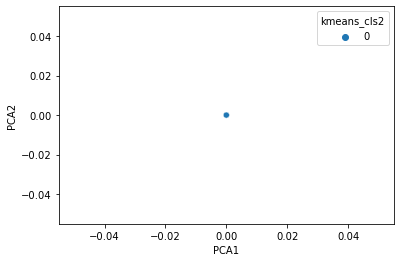

In [442]:
import seaborn as sns
sns.scatterplot(data=window_reads,x='PCA1',y='PCA2',hue='kmeans_cls2')